In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

f(3.0)

20.0

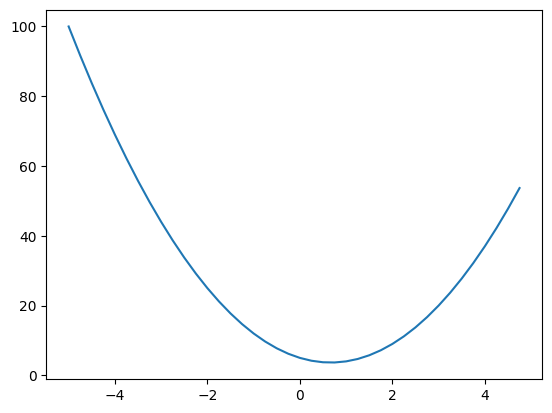

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)

plt.plot(xs, ys)

d(f(x))/dx means

lim h--> 0 { (f(x+h) - f(x)) / h }

*It basically means the change in the output of function if there is very slight change in input value*

In [5]:
# differentiation of fx
h = 0.0000001
x = 2/3

(f(x+h) - f(x))/h

2.9753977059954195e-07

In [6]:
# try with complex one
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [7]:
h = 0.0001

d1 = a*b + c

a += h
d2 = a*b + c

print('d1: ', d1)
print('d2: ', d2)
# change in d if a is changed very slightly
slope = (d2 - d1) / h
print('slope: ', slope)

d1:  4.0
d2:  3.999699999999999
slope:  -3.000000000010772


In [8]:
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c

b += h
d2 = a*b + c

print('d1: ', d1)
print('d2: ', d2)
# change in d if b is changed very slightly
slope = (d2 - d1) / h
print('slope: ', slope)

d1:  4.0
d2:  4.0002
slope:  2.0000000000042206


In [9]:
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c

c += h
d2 = a*b + c

print('d1: ', d1)
print('d2: ', d2)
# change in d if b is changed very slightly
slope = (d2 - d1) / h
print('slope: ', slope)

d1:  4.0
d2:  4.0001
slope:  0.9999999999976694


In [10]:
# data structure container
class Value:
    def __init__(self, data, _children=(), _op='', label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children) # to store the intermidiate results of the bigger operation
        self._op = _op # to know which operation caused that intermidiate result
        self.label = label

    # representation container
    # if not defined then it will show memory location like <__main__.Value at 0x788a537fe810>
    def __repr__(self):
        return f"Value(data={self.data})"

    # arithmetic operation
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        output = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += (1 * output.grad)
            other.grad += (1 * output.grad)
        output._backward = _backward
        return output

    def __sub__(self, other): # self - other
        return self + (-other)

    def __neg__(self): # -self
        return self * -1

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        output = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += (other.data * output.grad)
            other.grad += (self.data * output.grad)
        output._backward = _backward
        return output

    # fallback method to perform '3*a' kind of operation
    def __rmul__(self, other): # other * self
        return self*other

    def __pow__(self, other): 
        assert isinstance(other, (int, float)), "only supports int/floats"
        output = Value(self.data ** other, (self, ), f"**{other}")

        def _backward():
            self.grad += (other * (self.data ** (other - 1))) * output.grad
        output._backward = _backward
        return output

    def __truediv__(self, other): # self / other
        # a/b = a * (b**-1)
        return self * (other ** -1)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += ((1 - t**2) * out.grad)
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        output = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += (output.data * output.grad)
        output._backward = _backward
        return output

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v): # v --> root node
            # same as graph traversal logic
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [11]:
# visual representation to see the series of operations
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set() # set of all nodes and edges
    def build(v):
        if v not in nodes: # check each node
            nodes.add(v)
            # connect every child which involved 'v' for that operation 
            # and connect them with an edge
            for child in v._prev: 
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': "LR"}) # left -> right (flow)

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n)) # for unique identification of each node
        # for any value in graph, create rectangular(record) node for it
        dot.node(name = uid, label="{ %s | data %.4f} | grad %.4f" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation then create an op node for it
            dot.node(name=uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [12]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0, label='x2')

# weights and bias
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2w2'
n = x1w1x2w2 + b; n.label= 'n'

o = n.tanh(); o.label='o'

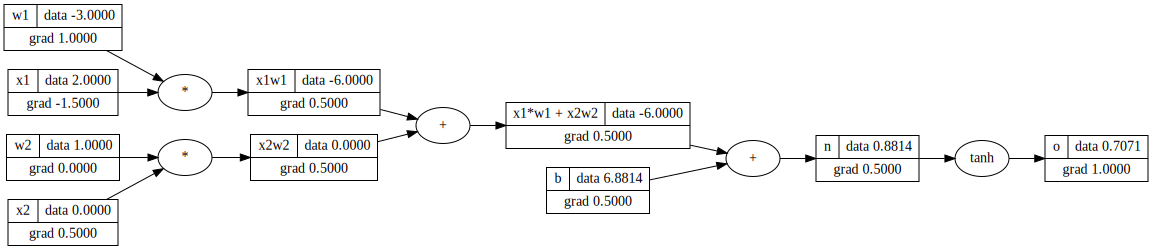

In [13]:
o.backward()
draw_dot(o)

Currently our class is incapable of performing scaler operations.  
eg. a = Value(3.0)  
**a + 1** (it will throw error)  

In [14]:
# now it's working as I added a code to handle that for other variable in class implementation
a = Value(4)
a*5

Value(data=20)

Now if I perform 'a + k' it'll be executed correctly but if I try to execute:  
**k + a** - it will throw error as python doesn't now the datatype of a (as it's dtype = Value)

In [15]:
a.exp()

Value(data=54.598150033144236)

In [16]:
b = Value(5)
a/b

Value(data=0.8)

In [17]:
a-b

Value(data=-1)

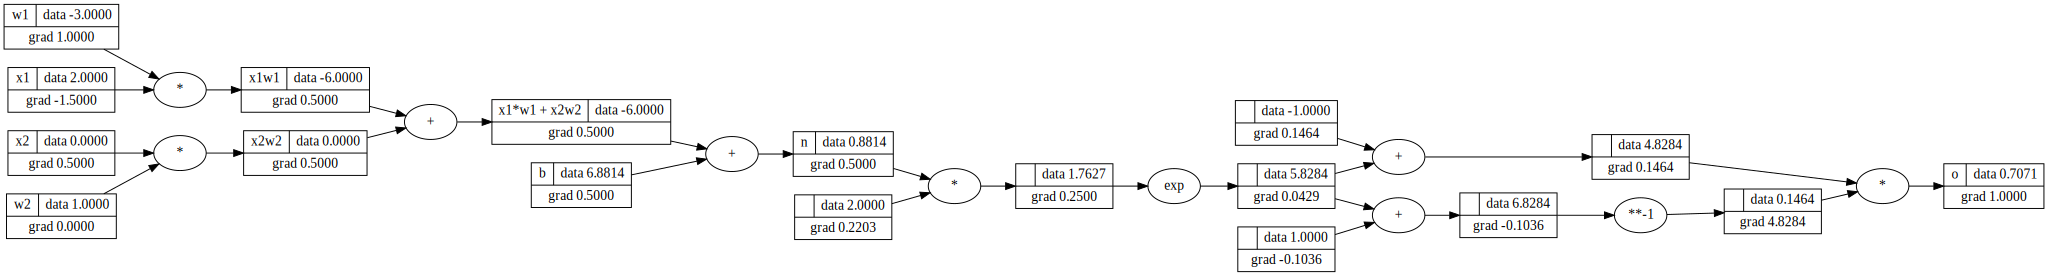

In [18]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0, label='x2')

# weights and bias
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2w2'
n = x1w1x2w2 + b; n.label= 'n'
# ---
e = (2*n).exp()
o = (e - 1)/(e + 1)
# ---
o.label='o'
o.backward()
draw_dot(o)